* Modeling wine preferences by data mining from physicochemical properties.

*BLUF: 
- It is possible to train a model 
- It is possible to modify the features to increase the F1 score


*QUESTIONS FOR INSTRUCTOR:
- What does it mean when the F1 score = 1?  Does this mean I likely did something wrong?
- In this notebook, I've trained a model using n_folds=12, but how do I save a 13th slice for testing the model?  Or is that happening already with the 12th slice and I don't realize it?
- Is it common to add/delete some of the features analyzed in order to improve a model's prediction?



* Input variables (based on physicochemical tests):
   1 - fixed acidity
   2 - volatile acidity
   3 - citric acid
   4 - residual sugar
   5 - chlorides
   6 - free sulfur dioxide
   7 - total sulfur dioxide
   8 - density
   9 - pH
   10 - sulphates
   11 - alcohol
   
   Output variable (based on sensory data): 
   12 - quality (score between 0 and 10)

* Background: 

Two datasets were created, using red and white wine samples.  **I only test the red samples in this notebook.  
 
Inputs include objective tests (e.g. PH values) and the output is based on sensory data (median of at least 3 evaluations made by wine experts). Each expert graded the wine quality between 0 (very bad) and 10 (very excellent). 
  
In the original ML analysis, several data mining methods were applied to model these datasets under a regression approach. The support vector machine model achieved the best results. Several metrics were computed: MAD, confusion matrix for a fixed error tolerance (T), etc. 
  
Also, we plot the relative importances of the input variables (as measured by a sensitivity analysis procedure).
  
These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are munch more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. 
  
**Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods.**

* Number of Instances: red wine - 1599; white wine - 4898. 

* Number of Attributes: 11 + output attribute
  
   Note: several of the attributes may be correlated, thus it makes sense to apply some sort of
   feature selection.

* Missing Attribute Values: None

In [31]:
%matplotlib inline

import os
import json
import time
import pickle
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [32]:
URL = "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

def fetch_data(fname='winequality-red.csv'):
    response = requests.get(URL)
    outpath = os.path.abspath(fname)
    
    with open(outpath, 'w') as f:
        f.write(response.content)
    
    return outpath

DATA = fetch_data()

In [33]:
FEATURES = [
   "fixed acidity",
   "volatile acidity",
   "citric acid",
   "residual sugar",
   "chlorides",
   "free sulfur dioxide",
   "total sulfur dioxide",
   "density",
   "pH",
   "sulphates",
   "alcohol",
   "quality"
]

# Label the wine quality rating
LABEL_MAP = {
    1: 1,
    2: 2,
    3: 3,
    4: 4,
    5: 5,
    6: 6,
    7: 7,
    8: 8,
    9: 9,
    10: 10,
    }

In [34]:
df = pd.read_csv(DATA, sep=';', header=0, names=FEATURES)

# Add the labels to the data
for k,v in LABEL_MAP.items():
    df.ix[df.quality == k, 'label'] = v

print df.head()

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                   11                    34   0.9978  3.51       0.56   
1                   25                    67   0.9968  3.20       0.68   
2                   15                    54   0.9970  3.26       0.65   
3                   17                    60   0.9980  3.16       0.58   
4                   11                    34   0.9978  3.51       0.56   

   alcohol  quality  label  
0      9.4        5      5  
1      9.8        5      5  

In [35]:
print df.describe()

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000         

In [36]:
# Determine shape of the data
print "{} instances with {} features\n".format(*df.shape)

# Determine frequency of each class
print df.groupby('label')['label'].count()

# Most red wine is considered a 5 or 6 out of 10 rating

1599 instances with 13 features

label
3         10
4         53
5        681
6        638
7        199
8         18
dtype: int64


In [53]:
# Check if there are any empty/missing values from the csv that would cause errors when we run the scikit-learn tools

df.isnull().values.any()

False

In [38]:
# Just for fun, read in the white wine csv

df2 = pd.read_csv('../data/wine-quality/winequality-white.csv', sep=';', header=0, names=FEATURES)
df2.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45,170,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14,132,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6


In [39]:
df2.isnull().values.any()

False

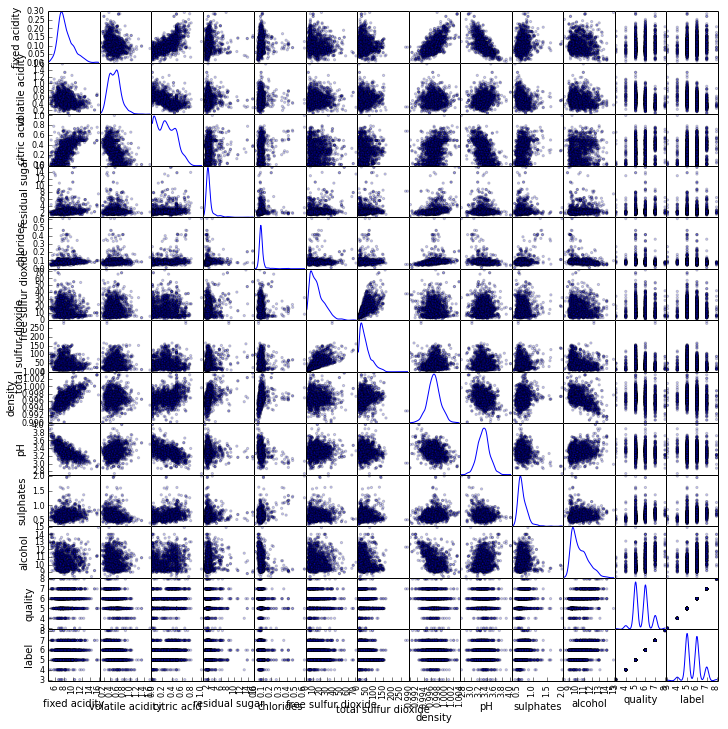

In [40]:
from pandas.tools.plotting import scatter_matrix

scatter_matrix(df, alpha=0.2, figsize=(12,12), diagonal='kde')
plt.show()

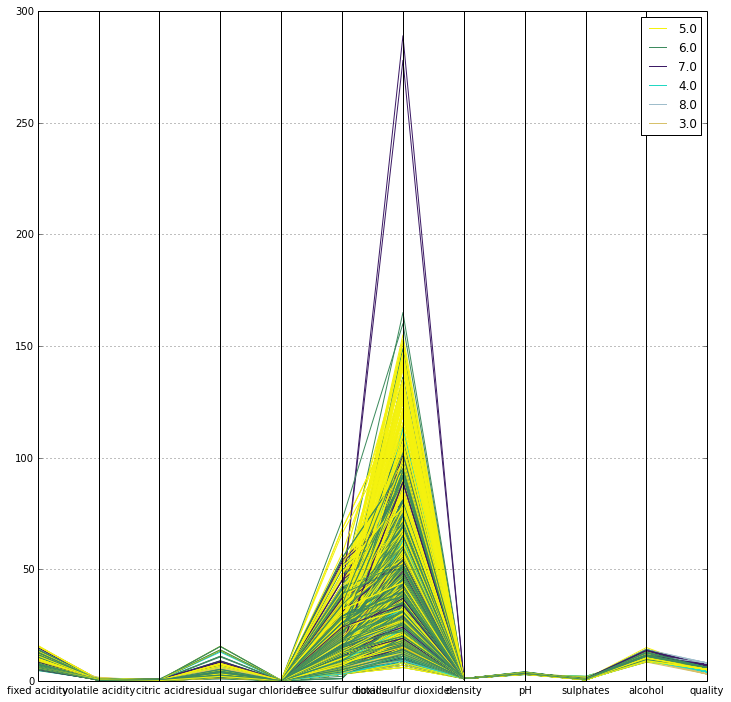

In [41]:
from pandas.tools.plotting import parallel_coordinates

plt.figure(figsize=(12,12))
parallel_coordinates(df, 'label')
plt.show()

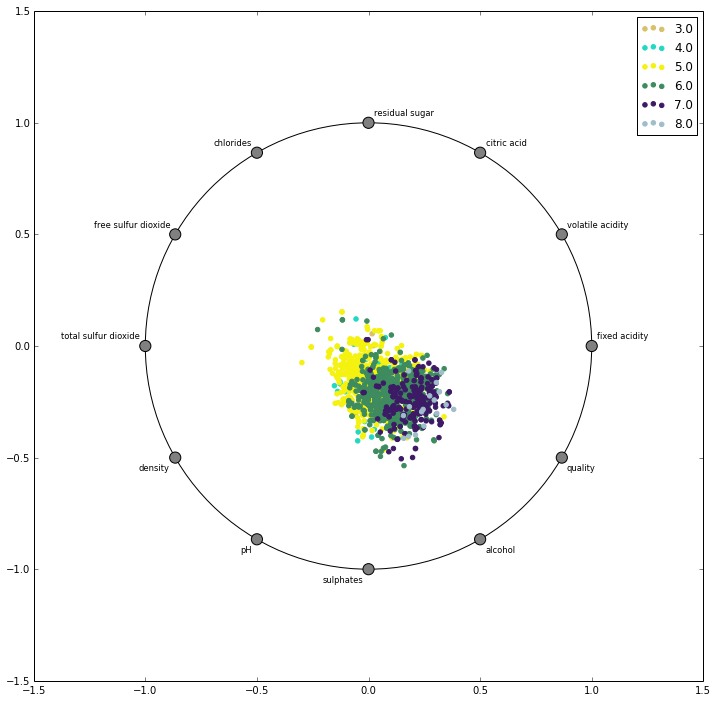

In [42]:
from pandas.tools.plotting import radviz
plt.figure(figsize=(12,12))
radviz(df, 'label')
plt.show()

In [43]:
df.to_csv('../data/wine-quality/winequality-red.csv')

In [44]:
from sklearn.datasets.base import Bunch

DATA_DIR = os.path.abspath(os.path.join(".", "..", "data", "wine-quality"))

for name in os.listdir(DATA_DIR):
    if name.startswith("."): continue
    print "-{}".format(name)

-winequality.names
-winequality-red4.csv
-winequality-red.csv
-winequality-white.csv


In [45]:
def load_data(root=DATA_DIR):
    filenames = {
        'data_red': os.path.join(root, 'winequality-red.csv'),
        'data_white': os.path.join(root, 'winequality-white.csv'),
        'data_red4': os.path.join(root, 'winequality-red4.csv'),
    }
    
    dataset = np.loadtxt(filenames['data_red'], delimiter=',', skiprows=1)
    
    # Extract the target from the data 
    data = dataset[:, 1: -1]
    target = dataset[:, -1]

    # Create the Bunch object
    return Bunch(
        data=data,
        target=target,
        filenames=filenames
    )
    

# Save dataset as a variable we can use
dataset = load_data()

print dataset.data
print dataset.target
 

[[  7.4     0.7     0.    ...,   0.56    9.4     5.   ]
 [  7.8     0.88    0.    ...,   0.68    9.8     5.   ]
 [  7.8     0.76    0.04  ...,   0.65    9.8     5.   ]
 ..., 
 [  6.3     0.51    0.13  ...,   0.75   11.      6.   ]
 [  5.9     0.645   0.12  ...,   0.71   10.2     5.   ]
 [  6.      0.31    0.47  ...,   0.66   11.      6.   ]]
[ 5.  5.  5. ...,  6.  5.  6.]


In [46]:
print dataset.data.shape
print dataset.target.shape

(1599, 12)
(1599,)


In [47]:
from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import KFold

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


In [48]:
def fit_and_eval(dataset, model, label, **kwargs):
    
    start = time.time() #starts the clock
    scores = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}
    
    for train, test in KFold(dataset.data.shape[0], n_folds=12, shuffle=True):
        X_train, X_test = dataset.data[train], dataset.data[test]
        y_train, y_test = dataset.target[train], dataset.target[test]
                
        estimator = model(**kwargs)
        estimator.fit(X_train, y_train)
        
        expected = y_test
        predicted = estimator.predict(X_test)
        
        # append scores to tracker
        scores['precision'].append(metrics.precision_score(expected, predicted, average='weighted'))
        scores['recall'].append(metrics.recall_score(expected, predicted, average='weighted'))
        scores['accuracy'].append(metrics.accuracy_score(expected, predicted))
        scores['f1'].append(metrics.f1_score(expected, predicted, average='weighted'))
        
        
        # report
        print "Build and Validation took {:0.3f} seconds.".format(time.time()-start)
        print "Validation scores are as follows:\n"
        print pd.DataFrame(scores).mean()
        
        # Write official estimator to disk
        estimator = model(**kwargs)
        estimator.fit(dataset.data, dataset.target)
    
        outpath = label.lower().replace(" ", "-") + ".pickle"
        with open(outpath, 'w') as f:
            pickle.dump(estimator, f)

        print "\nFitted model written to:\n{}".format(os.path.abspath(outpath))

In [49]:
fit_and_eval(dataset, SVC, "Wine SVM Classifier")

Build and Validation took 0.525 seconds.
Validation scores are as follows:

accuracy     0.813433
f1           0.795934
precision    0.791246
recall       0.813433
dtype: float64

Fitted model written to:
/home/liljfrk3/Desktop/Python/machine-learning/notebook/wine-svm-classifier.pickle
Build and Validation took 1.572 seconds.
Validation scores are as follows:

accuracy     0.802239
f1           0.777573
precision    0.767090
recall       0.802239
dtype: float64

Fitted model written to:
/home/liljfrk3/Desktop/Python/machine-learning/notebook/wine-svm-classifier.pickle
Build and Validation took 2.645 seconds.
Validation scores are as follows:

accuracy     0.808458
f1           0.787958
precision    0.779259
recall       0.808458
dtype: float64

Fitted model written to:
/home/liljfrk3/Desktop/Python/machine-learning/notebook/wine-svm-classifier.pickle
Build and Validation took 3.822 seconds.
Validation scores are as follows:

accuracy     0.807471
f1           0.785644
precision    0.7

In [50]:
fit_and_eval(dataset, KNeighborsClassifier, "Wine kNN Classifier", n_neighbors=12)

Build and Validation took 0.071 seconds.
Validation scores are as follows:

accuracy     0.634328
f1           0.609390
precision    0.685374
recall       0.634328
dtype: float64

Fitted model written to:
/home/liljfrk3/Desktop/Python/machine-learning/notebook/wine-knn-classifier.pickle
Build and Validation took 0.170 seconds.
Validation scores are as follows:

accuracy     0.582090
f1           0.552160
precision    0.596751
recall       0.582090
dtype: float64

Fitted model written to:
/home/liljfrk3/Desktop/Python/machine-learning/notebook/wine-knn-classifier.pickle
Build and Validation took 0.279 seconds.
Validation scores are as follows:

accuracy     0.582090
f1           0.556083
precision    0.583838
recall       0.582090
dtype: float64

Fitted model written to:
/home/liljfrk3/Desktop/Python/machine-learning/notebook/wine-knn-classifier.pickle
Build and Validation took 0.387 seconds.
Validation scores are as follows:

accuracy     0.575665
f1           0.551196
precision    0.5

In [52]:
fit_and_eval(dataset, RandomForestClassifier, "Wine Random Forest Classifier")

Build and Validation took 0.062 seconds.
Validation scores are as follows:

accuracy     0.970149
f1           0.966431
precision    0.963069
recall       0.970149
dtype: float64

Fitted model written to:
/home/liljfrk3/Desktop/Python/machine-learning/notebook/wine-random-forest-classifier.pickle
Build and Validation took 0.243 seconds.
Validation scores are as follows:

accuracy     0.970149
f1           0.965247
precision    0.969123
recall       0.970149
dtype: float64

Fitted model written to:
/home/liljfrk3/Desktop/Python/machine-learning/notebook/wine-random-forest-classifier.pickle
Build and Validation took 0.548 seconds.
Validation scores are as follows:

accuracy     0.975124
f1           0.970244
precision    0.972131
recall       0.975124
dtype: float64

Fitted model written to:
/home/liljfrk3/Desktop/Python/machine-learning/notebook/wine-random-forest-classifier.pickle
Build and Validation took 0.777 seconds.
Validation scores are as follows:

accuracy     0.973824
f1      

In [56]:
# Just for an experiment, what happens when I delete some of the features that,
# based on the parallel coordinates, don't have a clear delineation

# Read in the csv into a dataframe
df4 = pd.read_csv(DATA, sep=';', header=0, names=FEATURES)

# Label based on the wine quality rating
for k,v in LABEL_MAP.items():
    df4.ix[df4.quality == k, 'label'] = v
    
# Delete features that don't have a clear delineation amongst the ratings

df4 = df4.drop(['free sulfur dioxide'], axis=1)
df4 = df4.drop(['total sulfur dioxide', 'residual sugar'], axis=1)

df4.head()

,fixed acidity,volatile acidity,citric acid,chlorides,density,pH,sulphates,alcohol,quality,label
0,7.4,0.70,0.00,0.076,0.9978,3.51,0.56,9.4,5,5
1,7.8,0.88,0.00,0.098,0.9968,3.20,0.68,9.8,5,5
2,7.8,0.76,0.04,0.092,0.9970,3.26,0.65,9.8,5,5
3,11.2,0.28,0.56,0.075,0.9980,3.16,0.58,9.8,6,6
4,7.4,0.70,0.00,0.076,0.9978,3.51,0.56,9.4,5,5


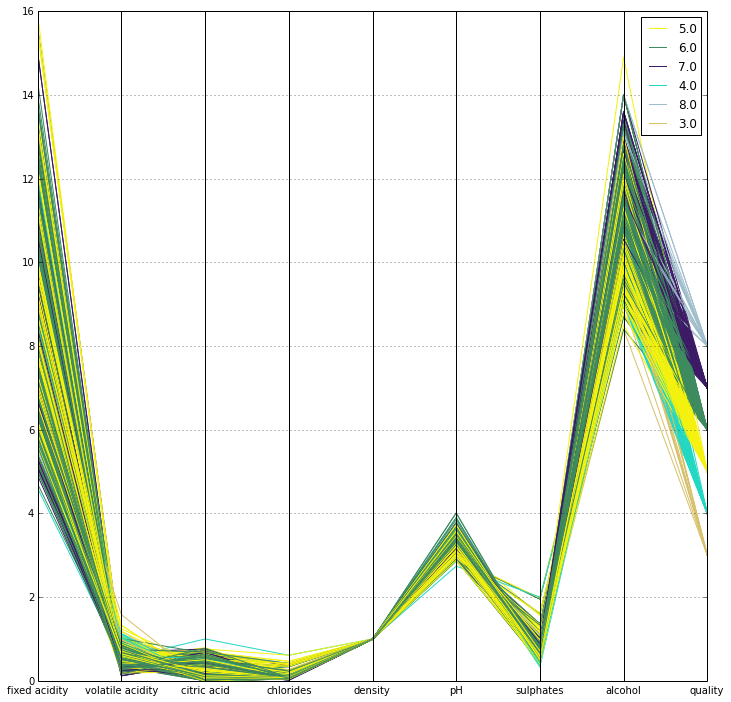

In [57]:
plt.figure(figsize=(12,12))
parallel_coordinates(df4, 'label')
plt.show()

In [58]:
df4.to_csv('../data/wine-quality/winequality-red4.csv')

In [60]:
def load_data4(root=DATA_DIR):
    filenames = {
        'data_red': os.path.join(root, 'winequality-red.csv'),
        'data_white': os.path.join(root, 'winequality-white.csv'),
        'data_red4': os.path.join(root, 'winequality-red4.csv'),
    }
    
    dataset = np.loadtxt(filenames['data_red4'], delimiter=',', skiprows=1)
    
    # Extract the target from the data 
    data = dataset[:, 1: -1]
    target = dataset[:, -1]

    # Create the Bunch object
    return Bunch(
        data=data,
        target=target,
        filenames=filenames
    )
    

# Save dataset as a variable we can use
dataset = load_data4()

print dataset.data
print dataset.target

[[  7.4     0.7     0.    ...,   0.56    9.4     5.   ]
 [  7.8     0.88    0.    ...,   0.68    9.8     5.   ]
 [  7.8     0.76    0.04  ...,   0.65    9.8     5.   ]
 ..., 
 [  6.3     0.51    0.13  ...,   0.75   11.      6.   ]
 [  5.9     0.645   0.12  ...,   0.71   10.2     5.   ]
 [  6.      0.31    0.47  ...,   0.66   11.      6.   ]]
[ 5.  5.  5. ...,  6.  5.  6.]


In [61]:
print dataset.data.shape
print dataset.target.shape

(1599, 9)
(1599,)


In [66]:
fit_and_eval(dataset, SVC, "Wine SVM Classifier v4")

Build and Validation took 0.095 seconds.
Validation scores are as follows:

accuracy     0.985075
f1           0.980761
precision    0.979975
recall       0.985075
dtype: float64

Fitted model written to:
/home/liljfrk3/Desktop/Python/machine-learning/notebook/wine-svm-classifier-v4.pickle
Build and Validation took 0.303 seconds.
Validation scores are as follows:

accuracy     0.992537
f1           0.990381
precision    0.989988
recall       0.992537
dtype: float64

Fitted model written to:
/home/liljfrk3/Desktop/Python/machine-learning/notebook/wine-svm-classifier-v4.pickle
Build and Validation took 0.525 seconds.
Validation scores are as follows:

accuracy     0.995025
f1           0.993587
precision    0.993325
recall       0.995025
dtype: float64

Fitted model written to:
/home/liljfrk3/Desktop/Python/machine-learning/notebook/wine-svm-classifier-v4.pickle
Build and Validation took 0.716 seconds.
Validation scores are as follows:

accuracy     0.992509
f1           0.990964
precisi

In [63]:
fit_and_eval(dataset, KNeighborsClassifier, "Wine kNN Classifier v4", n_neighbors=12)

Build and Validation took 0.012 seconds.
Validation scores are as follows:

accuracy     0.977612
f1           0.973546
precision    0.970915
recall       0.977612
dtype: float64

Fitted model written to:
/home/liljfrk3/Desktop/Python/machine-learning/notebook/wine-knn-classifier-v4.pickle
Build and Validation took 0.072 seconds.
Validation scores are as follows:

accuracy     0.970149
f1           0.962707
precision    0.956327
recall       0.970149
dtype: float64

Fitted model written to:
/home/liljfrk3/Desktop/Python/machine-learning/notebook/wine-knn-classifier-v4.pickle
Build and Validation took 0.130 seconds.
Validation scores are as follows:

accuracy     0.970149
f1           0.962241
precision    0.955420
recall       0.970149
dtype: float64

Fitted model written to:
/home/liljfrk3/Desktop/Python/machine-learning/notebook/wine-knn-classifier-v4.pickle
Build and Validation took 0.193 seconds.
Validation scores are as follows:

accuracy     0.960695
f1           0.949776
precisi

In [64]:
fit_and_eval(dataset, RandomForestClassifier, "Wine Random Forest Classifier v4")

Build and Validation took 0.067 seconds.
Validation scores are as follows:

accuracy     0.985075
f1           0.983867
precision    0.985218
recall       0.985075
dtype: float64

Fitted model written to:
/home/liljfrk3/Desktop/Python/machine-learning/notebook/wine-random-forest-classifier-v4.pickle
Build and Validation took 0.220 seconds.
Validation scores are as follows:

accuracy     0.992537
f1           0.991934
precision    0.992609
recall       0.992537
dtype: float64

Fitted model written to:
/home/liljfrk3/Desktop/Python/machine-learning/notebook/wine-random-forest-classifier-v4.pickle
Build and Validation took 0.534 seconds.
Validation scores are as follows:

accuracy     0.995025
f1           0.994622
precision    0.995073
recall       0.995025
dtype: float64

Fitted model written to:
/home/liljfrk3/Desktop/Python/machine-learning/notebook/wine-random-forest-classifier-v4.pickle
Build and Validation took 0.702 seconds.
Validation scores are as follows:

accuracy     0.99063
